In [2]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from sklearn.model_selection import (TimeSeriesSplit)
from sklearn.linear_model import (LinearRegression, BayesianRidge)
from sklearn.metrics import (mean_squared_error)
from sklearn.decomposition import (PCA)
from sklearn.tree import DecisionTreeRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import (MinMaxScaler, StandardScaler)

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

The goal of the project is to predict stock price movements and trends based on various different technical indicators for selected S&P 500 companies. 

* Use Linear Regression, Decision Tree, Naïve Bayes, and Neural Network models like Long Short-Term Memory (LSTM) to predict stock price based on different stock indicators using historical data.
* Many of these models are discussed in class
* Use k-fold cross-validation and principle component analysis (PCA) to obtain better fits
* Test the models with different S&P 500 stocks against actual stock price
* Pick the best model based on accuracy scores and errors like Root Mean Squared Error

kaggle data source: https://www.kaggle.com/nikhilkohli/us-stock-market-data-60-extracted-features

1. Get and preprocess data

In [3]:
companies = ['IBM','AAPL','JNJ']
price_types = ['open', 'close','high','low']

In [4]:
def rename_columns(old_name):
    if old_name[-5:] == '10-10':
        new_name = old_name[:-5] + '10' 
    elif old_name[-5:] == '20-20':
        new_name = old_name[:-5] + '20' 
    else:
        new_name = old_name
    return new_name

def get_data(company):
    daily = pd.read_csv('./data/daily_{}.csv'.format(company))
    open_ind = pd.read_csv('./data/open_ind_{}.csv'.format(company))
    close_ind = pd.read_csv('./data/close_ind_{}.csv'.format(company))
    high_ind = pd.read_csv('./data/high_ind_{}.csv'.format(company))
    low_ind = pd.read_csv('./data/low_ind_{}.csv'.format(company))

    open_ind.rename(columns=rename_columns, inplace=True)
    close_ind.rename(columns=rename_columns, inplace=True)
    high_ind.rename(columns=rename_columns, inplace=True)
    low_ind.rename(columns=rename_columns, inplace=True)
    
    return daily, open_ind, close_ind, high_ind, low_ind

In [5]:
def get_process_data(company):
    data = get_data(company) #(daily, open_ind, close_ind, high_ind, low_ind)
    X_list = []
    y_list = []
    for i in range(len(price_types)):
        combined = pd.concat([data[0],data[i+1]],axis=1)
        combined = combined[combined.isnull().any(axis=1)==False] # drop any columns that has NA, some indicators do not go further back, should start around the year 2000
        combined.rename({'Unnamed: 0': 'Date','1. open':'open', '2. high': 'high', '3. low': 'low', '4. close': 'close','6. volume': 'volume', '7. dividend amount': 'dividend'}, axis='columns',inplace=True)
        combined.drop('5. adjusted close',axis=1, inplace=True)
        combined.drop('8. split coefficient',axis=1, inplace=True)
        combined.set_index('Date',inplace=True)
        combined = combined.iloc[::-1]
        
        X = combined.iloc[:,4:]
        X_list.append(X)
        y = combined[[price_types[i]]]
        y_list.append(y)
        
    return X_list,y_list

In [6]:
X_list,y_list = get_process_data("IBM")

2. Time Series K Folds
, and
3. Standardize the Data using Training Set

In [7]:
def standardize_scale(dif_scaler, X_train, X_test, y_train, y_test):
    scaler_X=dif_scaler
    X_train_standardize = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_standardize = pd.DataFrame(scaler_X.transform(X_test),  columns=X_test.columns, index=X_test.index)
    
    scaler_Y=dif_scaler
    y_train_standardize = pd.DataFrame(scaler_Y.fit_transform(y_train), columns=y_train.columns, index=y_train.index)
    y_test_standardize = pd.DataFrame(scaler_Y.transform(y_test), columns=y_test.columns, index=y_test.index)

    X_train_standardize.insert(0,'bias',1)
    X_test_standardize.insert(0,'bias',1)
    
    return [X_train_standardize, X_test_standardize, y_train_standardize, y_test_standardize], [scaler_X, scaler_Y]

In [8]:
# perform PCA to reduce dimension so reduced features can explain 95% of variance
def perform_PCA(X_train, X_test, threshold=0.95):
    pca = PCA(n_components=threshold)
    pca.fit(X_train)
    reduced_X_train = pca.transform(X_train)
    reduced_X_test = pca.transform(X_test)
    return pd.DataFrame(reduced_X_train, index=X_train.index), pd.DataFrame(reduced_X_test, index=X_test.index)

In [9]:
# if n_steps=5, use 1,2,3,4,5th day indicator data to predict 6th day prices
def reshape_for_LTSM(X, y, n_steps=5):
    X_result = []
    s = X.shape[0] - n_steps
    for i in range(s):
        X_result.append(X.iloc[i:n_steps+i].values)  #2d array n_features x n_steps
    
    y_result = y.iloc[n_steps:,:]
    return np.array(X_result), y_result

In [10]:
def apply_LTSM(X_train, X_test, y_train, y_test, scaler, n_steps=5):
    X_train,y_train = reshape_for_LTSM(X_train, y_train, n_steps)
    X_test,y_test = reshape_for_LTSM(X_test, y_test)
#     print(X_train.shape)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    model.fit(X_train, y_train, epochs=30, verbose=0)
    y_predict = model.predict(X_test, verbose=0)
    
    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    
    return mean_squared_error(y_test_inverse, y_predict_inverse, squared=False), pd.DataFrame(y_predict_inverse, index = y_test.index), y_test, y_test_inverse

In [11]:
def implement_LSTM(X_list,y_list,PCA=True, k_folds=10, n_steps=5):
    ts_kfold = TimeSeriesSplit(k_folds)
    standardized_all_splits_by_price_type = []
    min_max_scaler_all_splits_by_price_type = []
    standardized_scalers_list = []
    minmax_scalers_list = []
    
    LSTM_rmse = pd.DataFrame()
    LSTM_prediction = []
    X_train_lists = []
    y_test_lists = []
    for index in range(len(X_list)): #open,close,high,low
        X=X_list[index]
        y=y_list[index]
        standardized_splits_by_price_type = []
        min_max_scaler_splits_by_price_type = []
        
        y_test_list = []
        X_train_list = []
        y_predict_list = []
        rmse_list = []
        
        standardized_scalers = []
        minmax_scalers = []
        start = 0
        each_fold_size = X.shape[0]//k_folds
        X_train_list = []
#         for train_index, test_index in ts_kfold.split(X):
#             X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#             y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        for i in range(k_folds):
            
            # blocking time series split
            if i == 0:
                fold_size = X.shape[0]%k_folds + each_fold_size
            else:
                fold_size = each_fold_size
            training_size = math.ceil(fold_size*0.75)

            X_train, X_test = X.iloc[start:start+training_size,:], X.iloc[start+training_size:start+fold_size, :]
            y_train, y_test = y.iloc[start:start+training_size,:], y.iloc[start+training_size:start+fold_size, :]
            start += fold_size
            
            min_max_data, scalers = standardize_scale(MinMaxScaler(feature_range=(0,1)), X_train, X_test, y_train, y_test)
            X_train, X_test, y_train, y_test = min_max_data
            if PCA:
                X_train, X_test = perform_PCA(X_train, X_test)
            min_max_scaler_splits_by_price_type.append([X_train, X_test, y_train, y_test])
            minmax_scalers.append(scalers)  # one for X and one for Y
            
            rmse, y_predict, y_test, y_test_inverse = apply_LTSM(X_train, X_test, y_train, y_test, scalers[1], n_steps)
#             y_predict = pd.DataFrame(y_predict, index = y_test.iloc[n_splits:,:].index)
            rmse_list.append(rmse)
            y_predict_list.append(y_predict)
            X_train_list.append(X_train)
            y_test_list.append(y_test)
#             y_test_list.append(y_test.iloc[n_splits:,:])
            
        min_max_scaler_all_splits_by_price_type.append(min_max_scaler_splits_by_price_type)
        minmax_scalers_list.append(minmax_scalers)
        
        LSTM_rmse[price_types[index]] = rmse_list
        LSTM_prediction.append(y_predict_list)
        X_train_lists.append(X_train_list)
        y_test_lists.append(y_test_list)
    return LSTM_rmse, LSTM_prediction, X_train_lists, y_test_lists

In [12]:
k_folds=10

In [13]:
def prepare_to_plot(prediction, X_train_lists, y_list, price_type, k_fold_idx = k_folds-1):
    price_type_idx = price_types.index(price_type)

    y_predict = prediction[price_type_idx][k_fold_idx]
    predict_idx = prediction[price_type_idx][k_fold_idx].index
    y_actual = y_list[price_type_idx].loc[predict_idx]

    train_idx = X_train_lists[price_type_idx][k_fold_idx].index
    y_before = y_list[price_type_idx].loc[train_idx]
    
    y_before.index = pd.to_datetime(y_before.index, format="%Y-%m-%d")
    y_actual.index = pd.to_datetime(y_actual.index, format="%Y-%m-%d")
    y_predict.index = pd.to_datetime(y_predict.index, format="%Y-%m-%d")
    
    return y_before, y_actual, y_predict

In [14]:
def plot(y_before, y_actual, y_predict, company, price_type):
    
    fig, ax = plt.subplots()

    plt.plot(y_before, label='before')
    plt.plot(y_predict, label='predicted')
    plt.plot(y_actual, label='actual')

    locator = mdates.AutoDateLocator(maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.title("Stock {} Price forecast for {} using LSTM\n with k-folds cross validation with blocking".format(price_type, company))
    plt.xlabel("Time")
    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper right")
    
    plt.show()
    
    fig.savefig('./image/{}_{}_price_forcast_using_LSTM_k_fold_with_blocking.png'.format(company, price_type))

In [15]:
# main code
def LSTM_prediction(companies, price_types, k_folds = 10, n_steps = 5, PCA=False):
    all_rmse = dict()
    all_prediction = dict()
    for company in companies:
        X_list,y_list = get_process_data(company)
        LSTM_rmse, LSTM_prediction, X_train_lists, y_test_lists  = implement_LSTM(X_list,y_list,PCA=PCA, k_folds=k_folds, n_steps=n_steps)
        all_rmse[company] = LSTM_rmse
        all_prediction[company] = LSTM_prediction
    return all_rmse, all_prediction, X_train_lists, y_test_lists

In [16]:
price_type = "open"

In [112]:
all_rmse_no_PCA, all_prediction_no_PCA, X_train_lists, y_test_lists = LSTM_prediction(companies, price_type)

In [17]:
all_rmse_PCA, all_prediction_PCA, X_train_lists, y_test_lists = LSTM_prediction(companies, price_type, PCA=True)

In [219]:
len(y_test_lists)

4

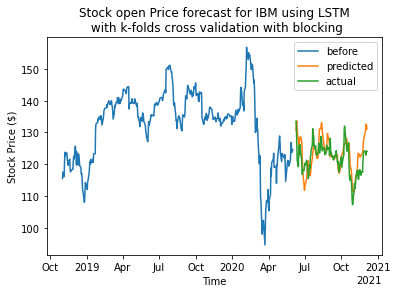

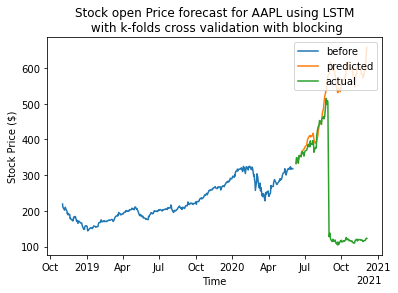

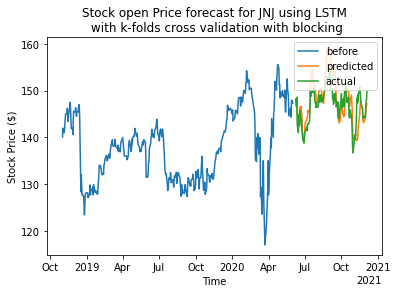

In [227]:
for company in companies:
    X_list,y_list = get_process_data(company)
    a = y_list[0]
    a.index = pd.to_datetime(a.index, format="%Y-%m-%d")
    X_train_lists[0][9].index = pd.to_datetime(X_train_lists[0][9].index, format="%Y-%m-%d")
    y_test_lists[0][9].index = pd.to_datetime(y_test_lists[0][9].index, format="%Y-%m-%d")
    y_actual = a.loc[y_test_lists[0][9].index]
    y_predict = all_prediction_PCA[company][0][9]
    y_before = a.loc[X_train_lists[0][9].index]

    y_before.index = pd.to_datetime(y_before.index, format="%Y-%m-%d")
    y_actual.index = pd.to_datetime(y_actual.index, format="%Y-%m-%d")
    y_predict.index = pd.to_datetime(y_predict.index, format="%Y-%m-%d")
    plot(y_before, y_actual, y_predict, company, 'open')

In [225]:
y_list[0].max()

open    702.41
dtype: float64

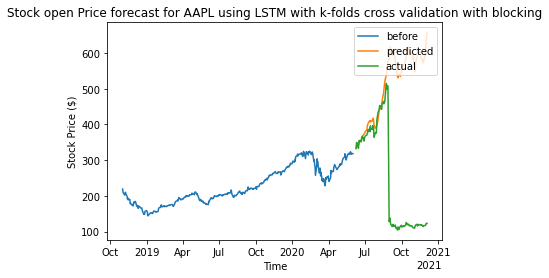

In [223]:
plot(y_before, y_actual, y_predict, company, 'open')

In [19]:
all_rmse_PCA['IBM'][['open']].to_csv('./temp/LSTM_blocking_rmse.csv')

In [18]:
all_rmse_PCA['IBM'][['open']]

,open
0,3.809931
1,4.527879
2,1.811945
3,3.772171
4,3.946628
5,4.898388
6,3.688728
7,8.859591
8,7.553288
9,5.019330


In [135]:
pca_no_pca = pd.DataFrame()
pca_no_pca['LSTM'] = [all_rmse_PCA['IBM'][['open']].loc[9].values[0], all_rmse_no_PCA['IBM'][['open']].loc[9].values[0]]
pca_no_pca.to_csv('./temp/LSTM_pca_no_pca_rmse.csv')

In [231]:
final_result = all_rmse_PCA['AAPL'].loc[[9]].T
final_result.columns = ['LSTM']
final_result.to_csv('./temp/LSTM_final_rmse.csv')

In [ ]:
for company in companies:
    rmse, prediction, standardized, y_list, X_train_lists = regression_prediction(companies, price_types, model_types, k_folds, n_steps)
    for model_type in model_types:
        plot(prediction, X_train_lists, y_list, company, price_type, model_type, k_fold_idx = k_folds-1)

In [116]:
pd.DataFrame(all_prediction_no_PCA).to_csv('./result/LSTM_blocking_prediction_no_PCA_{}.csv'.format(price_type))
pd.DataFrame.from_records([all_rmse_no_PCA]).to_csv('./result/LSTM_blocking_rmse__no_PCA{}.csv'.format(price_type))

In [111]:
pd.DataFrame(all_prediction_PCA).to_csv('./result/LSTM_blocking_prediction_PCA_{}.csv'.format(price_type))
pd.DataFrame.from_records([all_rmse_PCA]).to_csv('./result/LSTM_blocking_rmse__PCA{}.csv'.format(price_type))

In [ ]:
[X_train, X_test, y_train, y_test] = minMaxScaled[0][-1]

In [ ]:
apply_LTSM(X_train, X_test, y_train, y_test)